<a href="https://colab.research.google.com/github/elisabethnetland/tdt4173/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd
import os
import cv2
import pickle
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve, plot_precision_recall_curve
from keras.wrappers.scikit_learn import KerasClassifier
from google.colab import files


In [ ]:
#renaming real and fake directories
real = "/content/drive/My Drive/archive/real_and_fake_face/training_real"
fake = "/content/drive/My Drive/archive/real_and_fake_face/training_fake"
#we're creating a list of real and fake images
real_path = os.listdir(real)
print (real_path[0:10])
fake_path = os.listdir(fake)
shuffle(fake_path)
print (fake_path[0:10])
print (fake_path[890:920])

['real_00040.jpg', 'real_00147.jpg', 'real_00135.jpg', 'real_00092.jpg', 'real_00029.jpg', 'real_00053.jpg', 'real_00114.jpg', 'real_00038.jpg', 'real_00044.jpg', 'real_00050.jpg']
['hard_22_1111.jpg', 'easy_202_0011.jpg', 'mid_316_1111.jpg', 'mid_291_1100.jpg', 'mid_101_1111.jpg', 'easy_78_1111.jpg', 'easy_210_1011.jpg', 'mid_240_1100.jpg', 'mid_227_1111.jpg', 'hard_143_0100.jpg']
['hard_80_0100.jpg', 'easy_224_1100.jpg', 'easy_146_1110.jpg', 'hard_179_1111.jpg', 'mid_51_1111.jpg', 'hard_152_0111.jpg', 'hard_223_1111.jpg', 'easy_96_0011.jpg', 'easy_102_0101.jpg', 'hard_203_0010.jpg', 'mid_14_1101.jpg', 'hard_44_1111.jpg', 'easy_129_1111.jpg', 'mid_473_0011.jpg', 'mid_372_0011.jpg', 'hard_217_1100.jpg', 'mid_45_0010.jpg', 'mid_184_1101.jpg', 'mid_343_1111.jpg', 'easy_75_1100.jpg', 'easy_170_0010.jpg', 'mid_197_1110.jpg', 'mid_385_1100.jpg', 'mid_223_1111.jpg', 'mid_130_1111.jpg', 'mid_43_1111.jpg', 'easy_68_1100.jpg', 'hard_62_1010.jpg', 'mid_259_1101.jpg', 'mid_9_1110.jpg']


In [ ]:
img_size = 256
def create_training_data():
    training_data = []
    for img in tqdm(real_path[:865]):
        path = os.path.join(real, img)
        label = [1] 
        image = cv2.resize( cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size) )
        training_data.append([np.array(image), np.array(label)])
        
    for img in tqdm(fake_path[:768]):
        path = os.path.join(fake, img)
        label = [0] 
        image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        training_data.append([np.array(image), np.array(label)])
        
    

        
    shuffle(training_data) #shuffle data for more variability in training set
    return(training_data)

def create_test_data():
    test_data = []
    for img in tqdm(real_path[865:]):
        path = os.path.join(real, img)
        label = [1] 
        image = cv2.resize( cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size) )
        test_data.append([np.array(image), np.array(label)])
        
    for img in tqdm(fake_path[768:]):
        path = os.path.join(fake, img)
        label = [0] 
        image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        test_data.append([np.array(image), np.array(label)])
        
    
        
    shuffle(test_data) #shuffle data for more variability in training set
    return(test_data)  

#total training data with fake + real images, along with labels, converted to a grayscale
#adding data 2x to populate model more. Doing this bumped up accuracy from 60 to 70%

train_data = create_training_data()
test_data = create_test_data()

100%|██████████| 192/192 [00:13<00:00, 14.19it/s]


In [ ]:
X = []
y = []

for i in train_data:
    X.append(i[0])
    y.append(i[1])

    
#print(X[0].reshape(-1, 50, 50, 1))
X = np.array(X).reshape(-1, img_size, img_size, 1)


#divide by 255 to squish values to 0 - 1
X = X/255.0
y = np.array(y)

#we made X and y np arrays to be able to feed into the model
test_pic = []
test_lab = []


for i in test_data:
    test_pic.append(i[0])
    test_lab.append(i[1])
        
#print(X[0].reshape(-1, 50, 50, 1))
test_pic = np.array(test_pic).reshape(-1, img_size, img_size, 1)


#divide by 255 to squish values to 0 - 1
test_pic = test_pic/255.0
test_lab = np.array(test_lab)

In [ ]:
model = Sequential()

model.add(Conv2D(192,(5,3), input_shape=X.shape[1:], activation="relu")) 
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.6))

model.add(Conv2D(64,(3,3), activation="relu")) 
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.6))

model.add(Flatten()) 
model.add(Dense(192))

model.add(Activation("softmax")) 

opt = keras.optimizers.Adam(learning_rate=0.0002)

model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ['accuracy'])

history = model.fit(X, y, batch_size = 32, epochs = 70, verbose = 1, validation_split = 0.2)


Epoch 1/70
41/41 [==============================] - 5s 127ms/step - loss: 2.8351 - accuracy: 0.0015 - val_loss: 2.7197 - val_accuracy: 0.0000e+00
Epoch 2/70
41/41 [==============================] - 5s 123ms/step - loss: 2.8043 - accuracy: 0.0023 - val_loss: 2.7197 - val_accuracy: 0.0000e+00
Epoch 3/70
41/41 [==============================] - 5s 123ms/step - loss: 2.8043 - accuracy: 0.0054 - val_loss: 2.7197 - val_accuracy: 0.0000e+00
Epoch 4/70
41/41 [==============================] - 5s 123ms/step - loss: 2.8043 - accuracy: 0.0054 - val_loss: 2.7197 - val_accuracy: 0.0000e+00
Epoch 5/70
41/41 [==============================] - 5s 123ms/step - loss: 2.8043 - accuracy: 0.0046 - val_loss: 2.7197 - val_accuracy: 0.0000e+00
Epoch 6/70
41/41 [==============================] - 5s 124ms/step - loss: 2.8043 - accuracy: 0.0084 - val_loss: 2.7197 - val_accuracy: 0.0000e+00
Epoch 7/70
41/41 [==============================] - 5s 124ms/step - loss: 2.8043 - accuracy: 0.0069 - val_loss: 2.7197 - val

In [ ]:
model.save('my_cnn', save_format='tf')

model2 = keras.models.load_model('my_cnn') 
print(model2.summary())

INFO:tensorflow:Assets written to: my_cnn/assets
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 252, 254, 192)     3072      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 126, 127, 192)     0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 126, 127, 192)     0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 124, 125, 64)      110656    
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 62, 62, 64)        0         
_________________________________________________________________
flat

In [ ]:
yhat_probs = model2.predict(test_pic, verbose=0)
# predict crisp classes for test set
yhat_classes = model2.predict_classes(test_pic, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_lab, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_lab, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_lab, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_lab, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(test_lab, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(test_lab, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_lab, yhat_classes)
print(matrix)


average_precision = average_precision_score(test_lab, yhat_classes)


#disp = plot_precision_recall_curve(yhat_classes, test_pic, test_lab)
#disp.ax_.set_title('2-class Precision-Recall curve: '
                   #'AP={0:0.2f}'.format(average_precision))

IndexError: ignored

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
{'loss': [2.8350627422332764, 2.804288864135742, 2.8042852878570557, 2.80428409576416, 2.8042829036712646, 2.8042821884155273, 2.804281234741211, 2.804280996322632, 2.8042807579040527, 2.8042805194854736, 2.8042802810668945, 2.804279327392578, 2.804279327392578, 2.804279327392578, 2.8042795658111572, 2.80427885055542, 2.804279327392578, 2.804279327392578, 2.804279327392578, 2.804279088973999, 2.804279327392578, 2.80427885055542, 2.80427885055542, 2.804279327392578, 2.804279327392578, 2.804279327392578, 2.8042798042297363, 2.804279327392578, 2.804279327392578, 2.804279088973999, 2.804279088973999, 2.804279327392578, 2.804279088973999, 2.80427885055542, 2.804279088973999, 2.804279327392578, 2.804279327392578, 2.804279088973999, 2.804279088973999, 2.804279327392578, 2.8042798042297363, 2.804279088973999, 2.804279327392578, 2.804279088973999, 2.80427885055542, 2.804279327392578, 2.804279327392578, 2.804279327392578, 2.804279565811

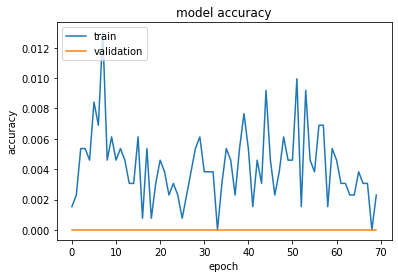

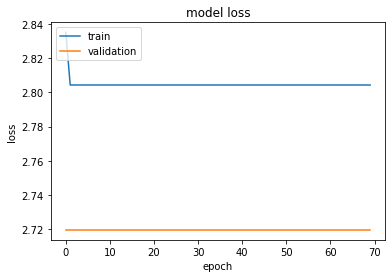

In [ ]:

# list all data in history
print(history.history.keys())
print(history.history)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

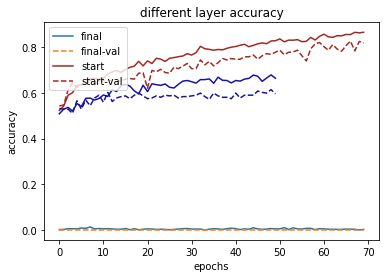

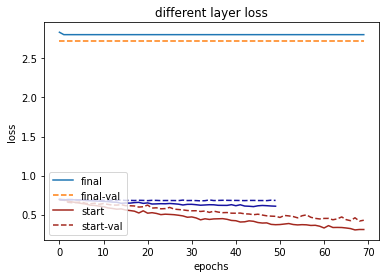

In [ ]:
fourloss = [0.6949512958526611, 0.6883362531661987, 0.6936812400817871, 0.690859854221344, 0.6880239248275757, 0.6874255537986755, 0.6801194548606873, 0.678334653377533, 0.6756106615066528, 0.6720670461654663, 0.6694214940071106, 0.6673656702041626, 0.660688579082489, 0.6590800285339355, 0.644843578338623, 0.64922696352005, 0.6472519636154175, 0.6541111469268799, 0.6573173403739929, 0.6441441178321838, 0.6503962278366089, 0.6358357071876526, 0.637750506401062, 0.6400550007820129, 0.6389811038970947, 0.6429720520973206, 0.6389197707176208, 0.6339741945266724, 0.6235248446464539, 0.631712019443512, 0.6322568655014038, 0.6268718242645264, 0.6205717921257019, 0.6238059997558594, 0.6269227862358093, 0.6259879469871521, 0.6195142865180969, 0.6187818050384521, 0.618350625038147, 0.6274817585945129, 0.6140837669372559, 0.6264725923538208, 0.609968364238739, 0.6074509620666504, 0.6027219891548157, 0.6131702661514282, 0.6172858476638794, 0.6144003868103027, 0.6105030179023743, 0.607960045337677]
fouracc = [0.5084226727485657, 0.5290964841842651, 0.5367534160614014, 0.5206738114356995, 0.5535987615585327, 0.5405819416046143, 0.576569676399231, 0.5773353576660156, 0.56891268491745, 0.5758039951324463, 0.5911179184913635, 0.5849923491477966, 0.6140888333320618, 0.6064318418502808, 0.6316998600959778, 0.6378254294395447, 0.6301684379577637, 0.6094946265220642, 0.5957121253013611, 0.6339969635009766, 0.6056661605834961, 0.6401225328445435, 0.6362940073013306, 0.6332312226295471, 0.639356791973114, 0.6248085498809814, 0.621745765209198, 0.6378254294395447, 0.6516079902648926, 0.654670774936676, 0.6493108868598938, 0.6431853175163269, 0.6584992408752441, 0.6584992408752441, 0.6615620255470276, 0.6424195766448975, 0.6692190170288086, 0.6554364562034607, 0.654670774936676, 0.6439509987831116, 0.654670774936676, 0.6516079902648926, 0.6607963442802429, 0.6638591289520264, 0.6784073710441589, 0.6730474829673767, 0.6508422493934631, 0.6653904914855957, 0.6791730523109436, 0.664624810218811]
fourval_loss = [0.6920070648193359, 0.6922621130943298, 0.6914477944374084, 0.6925894021987915, 0.6902734637260437, 0.6898252964019775, 0.6880096793174744, 0.6884276866912842, 0.6869227886199951, 0.6849172711372375, 0.6849147081375122, 0.6838962435722351, 0.6838605403900146, 0.6853176951408386, 0.6861519813537598, 0.6819127798080444, 0.6824138164520264, 0.6807264685630798, 0.6836436986923218, 0.6822962164878845, 0.6791082620620728, 0.6834331750869751, 0.682326078414917, 0.6797068119049072, 0.680997908115387, 0.6809393167495728, 0.6805290579795837, 0.6796665787696838, 0.6862643361091614, 0.6806014776229858, 0.6814168095588684, 0.6797996163368225, 0.676392138004303, 0.6786698698997498, 0.6884994506835938, 0.6802042126655579, 0.6820791363716125, 0.6838716864585876, 0.6830333471298218, 0.6821007132530212, 0.6818286180496216, 0.6809327006340027, 0.6796010136604309, 0.6818669438362122, 0.6819770932197571, 0.6806508898735046, 0.6806342005729675, 0.679220974445343, 0.6851068735122681, 0.6816772818565369]
fourval_acc = [0.5321100950241089, 0.5290519595146179, 0.5290519595146179, 0.5107033848762512, 0.5657492280006409, 0.5290519595146179, 0.5688073635101318, 0.5443425178527832, 0.5779816508293152, 0.5902140736579895, 0.5596330165863037, 0.6024464964866638, 0.5626911520957947, 0.5779816508293152, 0.5840978622436523, 0.5871559381484985, 0.574923574924469, 0.5902140736579895, 0.5993883609771729, 0.5871559381484985, 0.574923574924469, 0.5779816508293152, 0.5871559381484985, 0.5810397267341614, 0.5902140736579895, 0.5871559381484985, 0.5902140736579895, 0.5779816508293152, 0.5840978622436523, 0.5840978622436523, 0.5871559381484985, 0.5902140736579895, 0.5993883609771729, 0.5840978622436523, 0.571865439414978, 0.5993883609771729, 0.5871559381484985, 0.5810397267341614, 0.5810397267341614, 0.574923574924469, 0.5993883609771729, 0.5779816508293152, 0.5902140736579895, 0.5902140736579895, 0.5902140736579895, 0.608562707901001, 0.6024464964866638, 0.5993883609771729, 0.6146789193153381, 0.5963302850723267]

newloss = [0.6986653208732605, 0.693501889705658, 0.6916765570640564, 0.6924551725387573, 0.692897617816925, 0.692816972732544, 0.6900108456611633, 0.6871609091758728, 0.6857943534851074, 0.6797864437103271, 0.6784511804580688, 0.6669562458992004, 0.6707774996757507, 0.6636577844619751, 0.6619287133216858, 0.666054904460907, 0.6621803045272827, 0.654449462890625, 0.6519907712936401, 0.653764545917511, 0.6546404957771301, 0.6448609232902527, 0.6524166464805603, 0.649347722530365, 0.6401152014732361, 0.6366319060325623, 0.63667231798172, 0.6338860988616943, 0.6404215097427368, 0.6316708922386169, 0.6309012770652771, 0.633310079574585, 0.640476644039154, 0.6219879984855652, 0.6282616257667542, 0.6284849643707275, 0.6146230697631836, 0.6174435615539551, 0.6198920607566833, 0.6168186664581299, 0.6215291023254395, 0.6190077066421509, 0.6047258377075195, 0.6106266379356384, 0.6076516509056091, 0.6010172367095947, 0.6047652959823608, 0.6049933433532715, 0.5995752215385437, 0.6103525161743164, 0.5873129963874817, 0.5948129296302795, 0.5866345763206482, 0.5902354121208191, 0.5850363373756409, 0.5889971852302551, 0.5711710453033447, 0.5781928896903992, 0.5857523679733276, 0.5770887732505798, 0.5755556225776672, 0.584895133972168, 0.5775907635688782, 0.5692856311798096, 0.5719538331031799, 0.5576914548873901, 0.5678370594978333, 0.5501577854156494, 0.5491604804992676, 0.5563485622406006]
newacc = [0.5, 0.5267993807792664, 0.5344563722610474, 0.5344563722610474, 0.5153139233589172, 0.535222053527832, 0.5329249501228333, 0.5497702956199646, 0.5597243309020996, 0.5781010985374451, 0.5781010985374451, 0.6102603077888489, 0.601837694644928, 0.6148545145988464, 0.6079632639884949, 0.586523711681366, 0.6026033759117126, 0.5918835997581482, 0.6133231520652771, 0.6163859367370605, 0.6148545145988464, 0.6355283260345459, 0.604134738445282, 0.6332312226295471, 0.6500765681266785, 0.63705974817276, 0.6339969635009766, 0.6408882141113281, 0.6355283260345459, 0.6516079902648926, 0.6508422493934631, 0.6439509987831116, 0.6408882141113281, 0.6676875948905945, 0.6454823613166809, 0.6447166800498962, 0.6539050340652466, 0.6692190170288086, 0.6493108868598938, 0.6615620255470276, 0.654670774936676, 0.664624810218811, 0.6761102676391602, 0.6661561727523804, 0.674578845500946, 0.6791730523109436, 0.6784073710441589, 0.6837671995162964, 0.6661561727523804, 0.6669219136238098, 0.674578845500946, 0.6898928284645081, 0.6891270875930786, 0.6845329403877258, 0.6868300437927246, 0.6937212944030762, 0.7067381143569946, 0.6921898722648621, 0.6807044148445129, 0.6906585097312927, 0.6868300437927246, 0.6998468637466431, 0.6891270875930786, 0.7067381143569946, 0.6952526569366455, 0.7189892530441284, 0.6937212944030762, 0.7197549939155579, 0.7151607871055603, 0.715926468372345]
newval_loss = [0.6901483535766602, 0.6906805634498596, 0.6900656819343567, 0.6899219751358032, 0.689150333404541, 0.6900001764297485, 0.6894384622573853, 0.6868930459022522, 0.6844719052314758, 0.6798796057701111, 0.6735132932662964, 0.6753659248352051, 0.6707940697669983, 0.6706404685974121, 0.6738272309303284, 0.6674408316612244, 0.6649298071861267, 0.6739027500152588, 0.6661199927330017, 0.6718372702598572, 0.6611554026603699, 0.6589345335960388, 0.6618505120277405, 0.6581396460533142, 0.6555518507957458, 0.6608055233955383, 0.6584886908531189, 0.6586917638778687, 0.6623296141624451, 0.6603196263313293, 0.6592217087745667, 0.659310519695282, 0.6583558917045593, 0.6570144891738892, 0.6579672694206238, 0.658974289894104, 0.6563921570777893, 0.659678041934967, 0.6576414704322815, 0.6591028571128845, 0.6595916152000427, 0.6620222926139832, 0.6630145907402039, 0.6610743999481201, 0.6588855981826782, 0.6541144251823425, 0.6580880284309387, 0.6605691909790039, 0.6593990325927734, 0.6625693440437317, 0.6642902493476868, 0.6602946519851685, 0.664892315864563, 0.6702376008033752, 0.6594299674034119, 0.6620164513587952, 0.6693080067634583, 0.6745108962059021, 0.6592749357223511, 0.6627761721611023, 0.668705940246582, 0.6582759618759155, 0.6637400388717651, 0.6614673137664795, 0.6628154516220093, 0.6675905585289001, 0.6601410508155823, 0.665276050567627, 0.6624956727027893, 0.6624822616577148]
newval_acc = [0.538226306438446, 0.538226306438446, 0.538226306438446, 0.538226306438446, 0.538226306438446, 0.538226306438446, 0.538226306438446, 0.5657492280006409, 0.5626911520957947, 0.571865439414978, 0.5871559381484985, 0.5993883609771729, 0.5657492280006409, 0.5871559381484985, 0.5626911520957947, 0.5504587292671204, 0.5779816508293152, 0.5779816508293152, 0.5657492280006409, 0.571865439414978, 0.5902140736579895, 0.5871559381484985, 0.5840978622436523, 0.6116207838058472, 0.6116207838058472, 0.6116207838058472, 0.60550457239151, 0.5993883609771729, 0.5779816508293152, 0.6024464964866638, 0.5963302850723267, 0.60550457239151, 0.6116207838058472, 0.608562707901001, 0.6146789193153381, 0.6024464964866638, 0.608562707901001, 0.60550457239151, 0.608562707901001, 0.6269113421440125, 0.608562707901001, 0.5993883609771729, 0.6146789193153381, 0.6116207838058472, 0.6146789193153381, 0.639143705368042, 0.5993883609771729, 0.60550457239151, 0.5871559381484985, 0.5810397267341614, 0.5963302850723267, 0.6207951307296753, 0.6116207838058472, 0.6024464964866638, 0.608562707901001, 0.6299694180488586, 0.6146789193153381, 0.5963302850723267, 0.6116207838058472, 0.6024464964866638, 0.5902140736579895, 0.6207951307296753, 0.6116207838058472, 0.6146789193153381, 0.6116207838058472, 0.608562707901001, 0.5932721495628357, 0.5963302850723267, 0.60550457239151, 0.608562707901001]

testloss = [0.6947479248046875, 0.6898362636566162, 0.6747643351554871, 0.6617971658706665, 0.6527532935142517, 0.6434581875801086, 0.6355833411216736, 0.6209131479263306, 0.6176550984382629, 0.6089867949485779, 0.6022085547447205, 0.5860844850540161, 0.5791385769844055, 0.5695882439613342, 0.5737161636352539, 0.5591678619384766, 0.5523858070373535, 0.5443630814552307, 0.5213210582733154, 0.5490981936454773, 0.518638014793396, 0.5248774886131287, 0.5154470801353455, 0.5000668168067932, 0.5057819485664368, 0.5028485059738159, 0.49931132793426514, 0.4922443628311157, 0.48354583978652954, 0.46665340662002563, 0.47079962491989136, 0.45756813883781433, 0.43344947695732117, 0.4468683898448944, 0.43868696689605713, 0.4452577829360962, 0.446737676858902, 0.44879329204559326, 0.44020339846611023, 0.42566052079200745, 0.42195987701416016, 0.4055509865283966, 0.40829771757125854, 0.4205321669578552, 0.4148159921169281, 0.3990336060523987, 0.39231160283088684, 0.39429202675819397, 0.37524139881134033, 0.37113770842552185, 0.37320974469184875, 0.3797438144683838, 0.38619670271873474, 0.3736536204814911, 0.3684230148792267, 0.37157970666885376, 0.3696388900279999, 0.3616456687450409, 0.36363741755485535, 0.35167109966278076, 0.32911980152130127, 0.3593619465827942, 0.3352944254875183, 0.33629441261291504, 0.335144966840744, 0.3291231393814087, 0.3214032053947449, 0.3044023811817169, 0.30981701612472534, 0.30957266688346863]
testacc = [0.5233537554740906, 0.5424961447715759, 0.5899693965911865, 0.6010719537734985, 0.6316998600959778, 0.6378254294395447, 0.6362940073013306, 0.6611791849136353, 0.663476288318634, 0.6604135036468506, 0.665773332118988, 0.6837671995162964, 0.6921898722648621, 0.6986983418464661, 0.6902756690979004, 0.7036753296852112, 0.7120980024337769, 0.7174578905105591, 0.7385145425796509, 0.7186064124107361, 0.7404288053512573, 0.7289433479309082, 0.7519142627716064, 0.7480857372283936, 0.7381317019462585, 0.7519142627716064, 0.7549770474433899, 0.758805513381958, 0.7618682980537415, 0.7722052335739136, 0.7660796046257019, 0.776416540145874, 0.8043644428253174, 0.7936447262763977, 0.7909647822380066, 0.7871363162994385, 0.7905819416046143, 0.7886676788330078, 0.7955589294433594, 0.8005359768867493, 0.8035987615585327, 0.8089586496353149, 0.8131699562072754, 0.8024502396583557, 0.8085758090019226, 0.8154670596122742, 0.8192955851554871, 0.8158499002456665, 0.827718198299408, 0.8288667798042297, 0.8369066119194031, 0.8238897323608398, 0.8315467238426208, 0.8311638832092285, 0.8334609270095825, 0.8246554136276245, 0.8261868357658386, 0.8434150218963623, 0.8319295644760132, 0.8480091691017151, 0.8575804233551025, 0.8457121253013611, 0.8437978625297546, 0.8506891131401062, 0.8503062725067139, 0.8564318418502808, 0.8556661605834961, 0.8656201958656311, 0.8633231520652771, 0.8660030364990234]
val_loss = [0.689949095249176, 0.6858195662498474, 0.6573386192321777, 0.6517412662506104, 0.6569773554801941, 0.6624587178230286, 0.6439135074615479, 0.6396453976631165, 0.6459031701087952, 0.6327832937240601, 0.641399085521698, 0.6310139894485474, 0.622877836227417, 0.6219265460968018, 0.6274890303611755, 0.6149093508720398, 0.6134828329086304, 0.6111539602279663, 0.5968058705329895, 0.6012891530990601, 0.6223511099815369, 0.5841895341873169, 0.5876407027244568, 0.5747193694114685, 0.5774730443954468, 0.5926879644393921, 0.570833146572113, 0.5654747486114502, 0.5603739619255066, 0.5529080629348755, 0.5492077469825745, 0.5500035881996155, 0.5405343770980835, 0.5462977886199951, 0.5287429094314575, 0.544950544834137, 0.5325502157211304, 0.5252854228019714, 0.5268880128860474, 0.5187003016471863, 0.5182322263717651, 0.5201282501220703, 0.5101428627967834, 0.5079560279846191, 0.4989701807498932, 0.5056400299072266, 0.49466875195503235, 0.4848636984825134, 0.48066577315330505, 0.47831612825393677, 0.4640376567840576, 0.48952874541282654, 0.48393017053604126, 0.4754398465156555, 0.4591212272644043, 0.4856165945529938, 0.49718472361564636, 0.46598106622695923, 0.4523484408855438, 0.44460415840148926, 0.4516412913799286, 0.45187339186668396, 0.43412211537361145, 0.4461701512336731, 0.470668226480484, 0.4359472095966339, 0.42254838347435, 0.45987802743911743, 0.4176577031612396, 0.4284113645553589]
val_acc = [0.5428134799003601, 0.5474005937576294, 0.6146789193153381, 0.6452599167823792, 0.6253822445869446, 0.6314984560012817, 0.6590213775634766, 0.6574923396110535, 0.639143705368042, 0.6529052257537842, 0.6544342637062073, 0.6559633016586304, 0.6544342637062073, 0.646789014339447, 0.6544342637062073, 0.6605504751205444, 0.6636085510253906, 0.6605504751205444, 0.6865443587303162, 0.6880733966827393, 0.6207951307296753, 0.6987767815589905, 0.6926605701446533, 0.7033638954162598, 0.6896024346351624, 0.6865443587303162, 0.7125382423400879, 0.7064220309257507, 0.7171253561973572, 0.7293577790260315, 0.7064220309257507, 0.7064220309257507, 0.7446483373641968, 0.7232415676116943, 0.7385321259498596, 0.718654453754425, 0.7324159145355225, 0.7507645487785339, 0.7446483373641968, 0.7507645487785339, 0.747706413269043, 0.747706413269043, 0.7584097981452942, 0.7584097981452942, 0.7660550475120544, 0.747706413269043, 0.7629969716072083, 0.7721712589263916, 0.7691131234169006, 0.7782874703407288, 0.7874617576599121, 0.7675840854644775, 0.7782874703407288, 0.7798165082931519, 0.7874617576599121, 0.7629969716072083, 0.7400611639022827, 0.7935779690742493, 0.8149847388267517, 0.8211008906364441, 0.8027523159980774, 0.7874617576599121, 0.8119266033172607, 0.7920489311218262, 0.7828746438026428, 0.8073394298553467, 0.8272171020507812, 0.7844036817550659, 0.8256880640983582, 0.819571852684021]


# summarize history for accuracy
plt.plot(history.history['accuracy'] )
plt.plot(history.history['val_accuracy'], linestyle = 'dashed')
plt.plot(testacc, color = '#a3281f')
plt.plot(val_acc,linestyle = 'dashed', color = '#a3281f')
plt.plot(fouracc, color = '#1613a1')
plt.plot(fourval_acc, linestyle = 'dashed', color = '#1613a1')
plt.title('different layer accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['final', 'final-val','start', 'start-val'], loc='upper left')
plt.show()


# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], linestyle = 'dashed')
plt.plot(testloss, color = '#a3281f')
plt.plot(val_loss,linestyle = 'dashed', color = '#a3281f')
plt.plot(fourloss, color = '#1613a1')
plt.plot(fourval_loss, linestyle = 'dashed', color = '#1613a1')
plt.title('different layer loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['final', 'final-val','start', 'start-val'], loc='lower left')
plt.show()


In [ ]:
#let us make the model
hehis = sje
model = Sequential()

model.add(Conv2D(128,(3,3), input_shape=X.shape[1:])) 
model.add(Activation("relu")) 
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3))) 
model.add(Activation("relu")) 
model.add(MaxPooling2D(pool_size=(2,2)))



model.add(Dropout(0.5))

model.add(Conv2D(32,(2,2))) 
model.add(Activation("relu")) 
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.5))

model.add(Flatten()) 
model.add(Dense(128))

model.add(Dense(1)) 
model.add(Activation("softmax"))

opt = keras.optimizers.Adam(learning_rate=0.0002)

model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ['accuracy'])

history = model.fit(X, y, batch_size = 16, epochs = 30, verbose = 1, validation_split = 0.2)


# test_loss, test_accuracy = model.evaluate(test_data, test_lab)

def create_model():
  model = Sequential()

  model.add(Conv2D(128,(3,3), input_shape=X.shape[1:])) 
  model.add(Activation("relu")) 
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(32,(3,3))) 
  model.add(Activation("relu")) 
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Dropout(0.5))

  model.add(Conv2D(32,(2,2))) 
  model.add(Activation("relu")) 
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(32,(2,2))) 
  model.add(Activation("relu")) 
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Dropout(0.5))

  model.add(Flatten()) 
  model.add(Dense(128))

  model.add(Dense(1)) 
  model.add(Activation("sigmoid"))

  opt = keras.optimizers.Adam(learning_rate=0.0002)

  model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, verbose=1)
# define the grid search parameters
batch_size = [8, 16, 32]
epochs = [10, 30, 50, 70]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X, y, verbose = 1)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

    for img in tqdm(real_path[:865]):
        path = os.path.join(real, img)
        label = [1] 
        image = cv2.resize( cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size) )
        training_data.append([np.array(image), np.array(label)])
        
    for img in tqdm(fake_path[:768]):
        path = os.path.join(fake, img)
        label = [0] 
        image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        training_data.append([np.array(image), np.array(label)])
        
 
 
 
     for img in tqdm(real_path[866:]):
        path = os.path.join(real, img)
        label = [1] 
        image = cv2.resize( cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size) )
        test_data.append([np.array(image), np.array(label)])
        
    for img in tqdm(fake_path[769:]):
        path = os.path.join(fake, img)
        label = [0] 
        image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        test_data.append([np.array(image), np.array(label)])   